In [2]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [4]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

Before training we need data! For this notebook we will use the FashionMNIST dataset. Which is available in [torchvision](https://pytorch.org/vision/stable/index.html)


In [ ]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(0.5)]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2)

## Convolutional model

In [5]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5) # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)  #modificar n_feature
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        #print('x entrando al forward', x.shape)
        x = self.conv1(x)
        #print('x después de la 1a convolución', x.shape)
        x = F.relu(x)
        #print('x después de la 1a relu', x.shape)
        x = self.maxpool(x)
        #print('x despúes del 1r maxpool', x.shape)
        x = self.conv2(x)
        #print('x después de la 2a convolución', x.shape)
        x = F.relu(x)
        #print('x después de la 2a relu', x.shape)
        x = self.maxpool(x)
        #print('x despúes del 2o maxpool', x.shape) ---> x despúes del 2o maxpool torch.Size([256, 6, 4, 4])
        #calcular dimensión espacial de x en este punto
        x = x.view(-1, self.n_feature*4*4)
        #print('x después del 1r view', x.shape) ---> x después del 1r view torch.Size([256, 96])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Exercise 1

The model defined above has a mismatch shape problem. Calculate the correct input dimension for `fc1` and change its definition in the `__init__()` method and the call to `x.view()` in the forward pass.



In [ ]:
torch.backends.cudnn.benchmark = True
learning_rate = 1e-2
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

output_size = 10  # there are 10 classes

model = CNN(6, output_size)

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

#initialize_parameters(model)

Number of parameters 6422:


# Exercise 2

- What does `torch.backends.cudnn.benchmark = True` do? 
- How will it affect our runtime if the size of the input images vary a lot?


`torch.backends.cudnn.benchmark = True` es una flag que habilita el modo de referencia en cudnn. De esta manera, cudnn buscará el conjunto óptimo de algoritmos para esa configuración en particular, lo que generalmente lleva a un tiempo de ejecución más rápido.

La flag es útil siempre que los tamaños de las input images no varíen, por lo que si el tamaño de las input images varía mucho, esta flag no será útil porque cudnn no podrá encontrar un conjunto óptimo de algoritmos.

In [9]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

# Exercise 3

Given the following convolutional layer:

`nn.Convd2(in_channels=3, out_channels=128, kernel_size=3)`

- What is the shape of the convolutional filter and its bias vector?
- What does each of the output channels represent?

### Run Training

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306727
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.180333
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.833010

Test set: Average loss: 0.0016, Accuracy: 6850/10000 (68%)



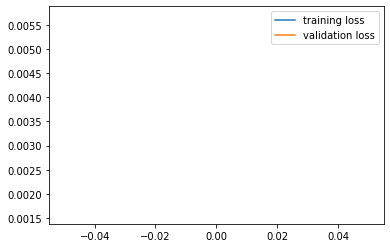

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.748782
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.703996
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.659684

Test set: Average loss: 0.0013, Accuracy: 7537/10000 (75%)



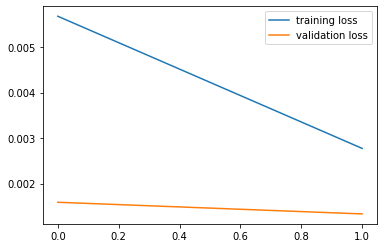

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.596943
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.622443
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.554862

Test set: Average loss: 0.0012, Accuracy: 7771/10000 (78%)



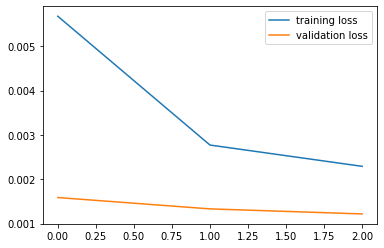

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.554560
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.597964
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.569396

Test set: Average loss: 0.0010, Accuracy: 8134/10000 (81%)



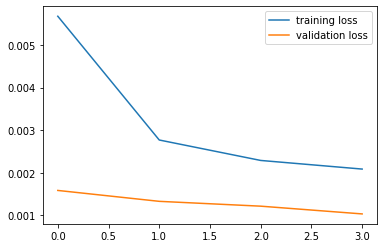

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.499911
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.495389
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.507242

Test set: Average loss: 0.0010, Accuracy: 8178/10000 (82%)



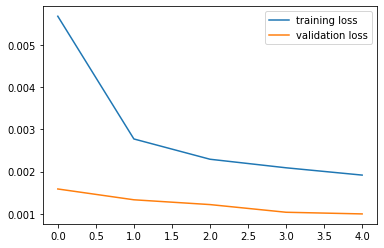

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.423244
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.469121
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.412822

Test set: Average loss: 0.0009, Accuracy: 8328/10000 (83%)



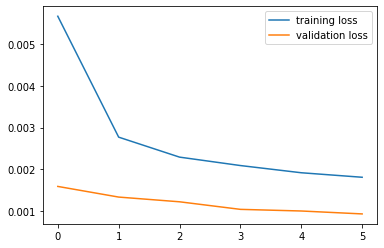

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.476710
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.417074
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.426784

Test set: Average loss: 0.0009, Accuracy: 8281/10000 (83%)



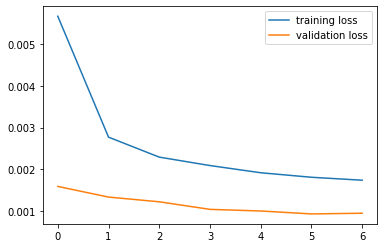

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.378347
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.403443
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.445741

Test set: Average loss: 0.0009, Accuracy: 8447/10000 (84%)



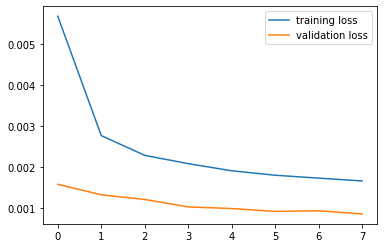

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.438648
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.396240
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.382890

Test set: Average loss: 0.0009, Accuracy: 8440/10000 (84%)



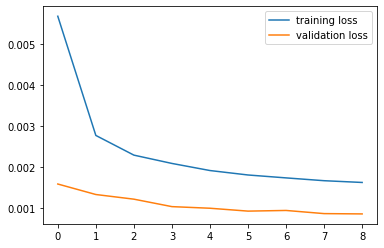

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.365354
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.459136
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.374780

Test set: Average loss: 0.0008, Accuracy: 8502/10000 (85%)



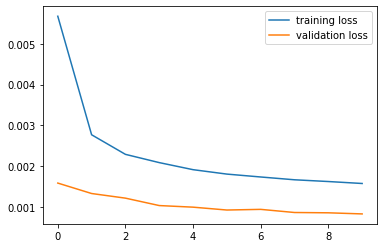

In [ ]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

# Homework

A) Train the same model but with all of the pixels in each image permuted (permute all images in the same way), is the performance worse? If not why?


In [ ]:
#código extraido del lab anterior

perm = torch.randperm(784)

for i in range(len(train_loader.dataset.data)):
    image = train_loader.dataset.data[i]
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    train_loader.dataset.data[i] = image_perm

for i in range(len(val_loader.dataset.data)):
    image = val_loader.dataset.data[i]
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    val_loader.dataset.data[i] = image_perm

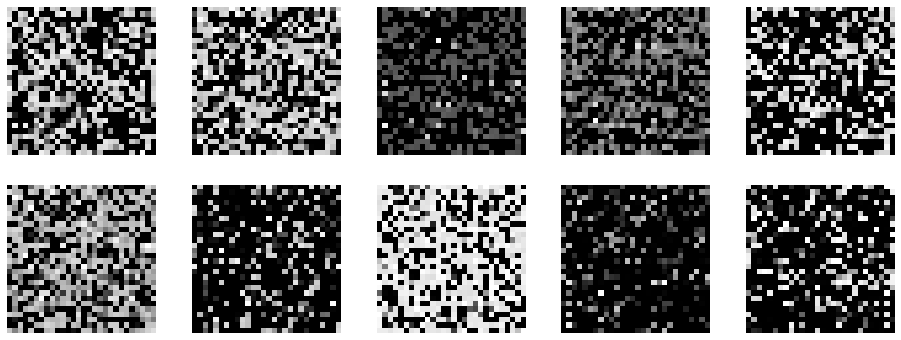

In [ ]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i +1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.552607
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.579337
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.512114

Test set: Average loss: 0.0013, Accuracy: 7641/10000 (76%)



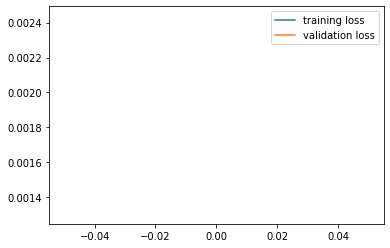

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.583129
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.621737
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.597281

Test set: Average loss: 0.0013, Accuracy: 7710/10000 (77%)



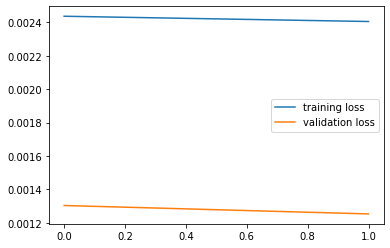

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.573626
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.496191
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.644494

Test set: Average loss: 0.0013, Accuracy: 7661/10000 (77%)



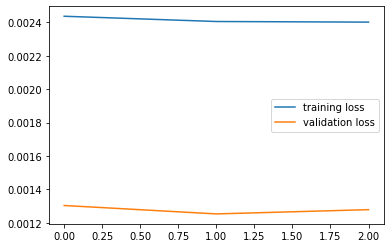

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.689947
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.654935
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.636343

Test set: Average loss: 0.0012, Accuracy: 7717/10000 (77%)



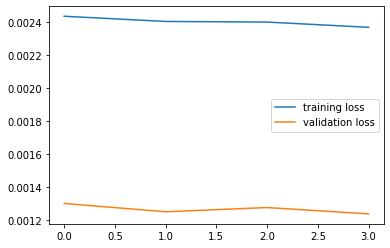

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.663910
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.548408
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.520098

Test set: Average loss: 0.0012, Accuracy: 7788/10000 (78%)



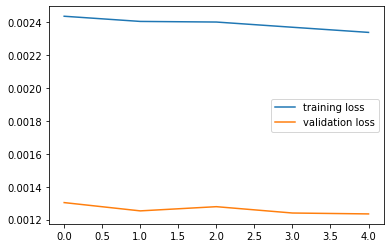

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.568821
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.634179
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.624716

Test set: Average loss: 0.0013, Accuracy: 7710/10000 (77%)



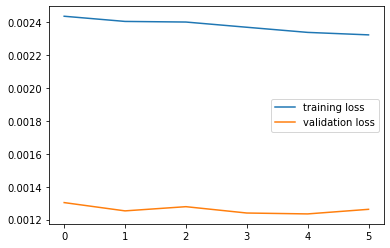

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.577523
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.589493
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.611916

Test set: Average loss: 0.0012, Accuracy: 7791/10000 (78%)



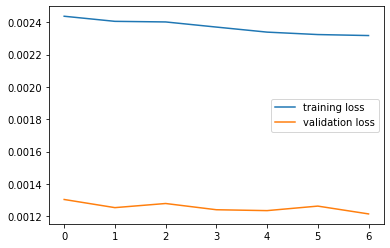

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.505142
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.663423
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.584704

Test set: Average loss: 0.0012, Accuracy: 7821/10000 (78%)



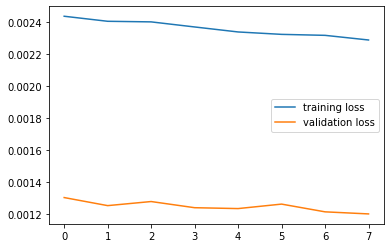

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.485814
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.519680
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.570099

Test set: Average loss: 0.0012, Accuracy: 7835/10000 (78%)



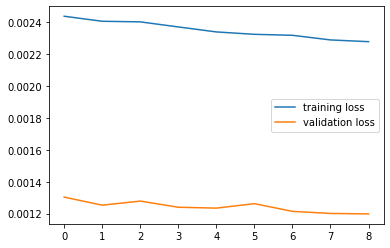

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.623190
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.504145
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.560031

Test set: Average loss: 0.0012, Accuracy: 7796/10000 (78%)



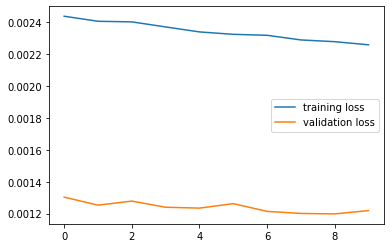

In [ ]:
#run training
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

Observamos que el modelo obtiene una accuracy buena (del 78%), por lo que entrenar el modelo pero con sus píxeles permutados no es problema.

B) With a trained model. Make prediction on 10 images, then, horizontally flip the same images and predict again. Is the performance the same? Why?

In [6]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(0.5)]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
torch.backends.cudnn.benchmark = True
learning_rate = 1e-2
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

output_size = 10  # there are 10 classes

model = CNN(6, output_size)

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

#initialize_parameters(model)

Number of parameters 6422:


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306727
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.180333
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.833010

Test set: Average loss: 0.0016, Accuracy: 6850/10000 (68%)



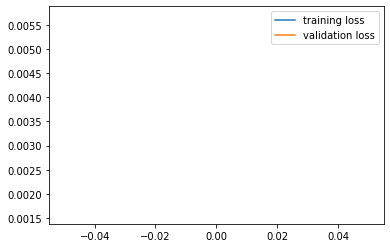

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.748782
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.703997
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.656328

Test set: Average loss: 0.0013, Accuracy: 7515/10000 (75%)



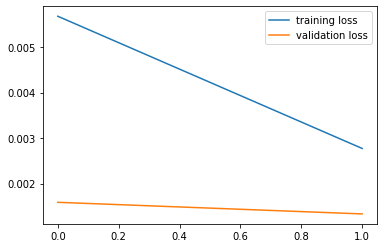

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.603639
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.624477
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.554099

Test set: Average loss: 0.0012, Accuracy: 7795/10000 (78%)



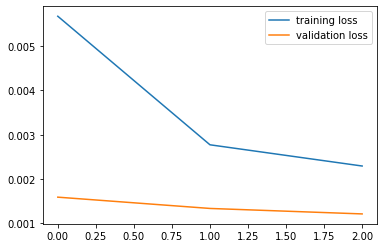

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.541516
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.592292
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.571441

Test set: Average loss: 0.0010, Accuracy: 8136/10000 (81%)



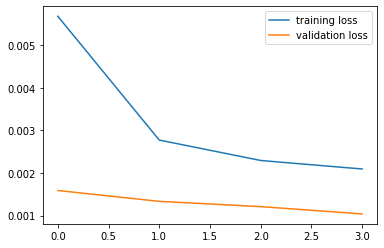

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.500869
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.498659
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.501156

Test set: Average loss: 0.0010, Accuracy: 8167/10000 (82%)



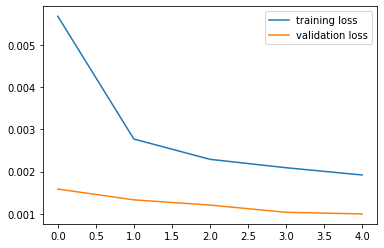

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.420145
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.474621
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.409340

Test set: Average loss: 0.0009, Accuracy: 8320/10000 (83%)



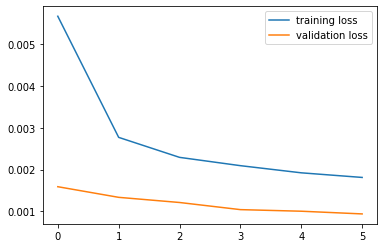

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.474867
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.421781
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.424660

Test set: Average loss: 0.0009, Accuracy: 8315/10000 (83%)



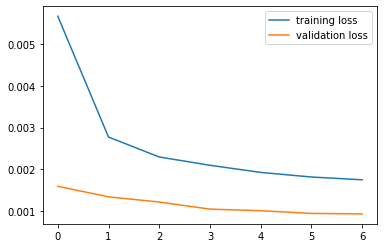

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.376855
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.407412
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.448225

Test set: Average loss: 0.0009, Accuracy: 8465/10000 (85%)



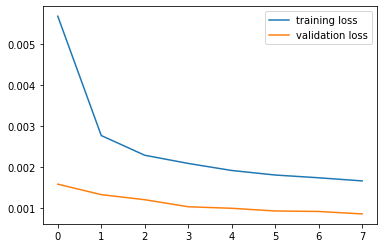

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.436081
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.386293
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.376352

Test set: Average loss: 0.0009, Accuracy: 8452/10000 (85%)



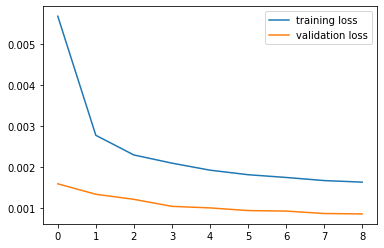

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.360355
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.461832
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.379286

Test set: Average loss: 0.0008, Accuracy: 8521/10000 (85%)



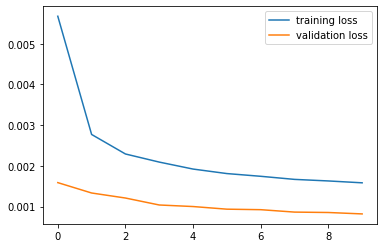

In [11]:
#run training
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

In [17]:
#código del lab anterior

y_pred_list = []
total = 0
len_data = len(val_loader.dataset)
with torch.no_grad():
    model.eval()
    for X_batch, target_y in val_loader:
        im = torch.flip(X_batch, [-3,2])  #hacemos el flip
        im = im.to(device)
        y_test_pred = model(im)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        target = target_y.tolist()  #línea añadida
        prediction = [ y.item() for y in y_pred_tags]  #línea añadida
        for y, yy in zip(target, prediction):  #línea añadida
          if y == yy: total+=1  #línea añadida
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print("Accuracy of {} with dataset_len {}".format(total/len_data, len_data))

Accuracy of 0.2358 with dataset_len 10000


Observamos que el modelo obtiene una accuracy muy mala (del 23%), por lo que validar el modelo con las imágenes giradas cuando lo hemos entrenado con las imágenes normales no da un buen resultado.

C) Visualize the feature maps of the first and last convolutional layers. What conclusions can you draw

In [ ]:
# In order to extract feature maps we will use forward hooks https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=hook#torch.nn.Module.register_forward_hook
data, targets = next(iter(val_loader))

data, targets = data[:10].to(device), targets[:10].to(device)

output_conv1 = []
output_conv2 = []

hooks = [model.conv1.register_forward_hook(lambda self, input, output: output_conv1.append(output)),
         model.conv2.register_forward_hook(lambda self, input, output: output_conv2.append(output))]


model(data)

print(len(output_conv1)) # output conv is a list with the feature maps
print(output_conv1[0].shape)
for hook in hooks:
    hook.remove()

1
torch.Size([10, 6, 24, 24])


In [ ]:
from PIL import Image
def imshow(map, img, ax):
    out = map.data.numpy()
    out = out - out.min()
    out = out / out.max()
    out = Image.fromarray(out)
    out = out.resize(img.shape[:2])

    out = plt.get_cmap('jet')(np.array(out))
    out = np.delete(out, 3, 2)    

    ax.axes.get_xaxis().set_visible(False)        
    ax.axes.get_yaxis().set_visible(False)
    a=0.5
    ax.imshow(a*out+(1-a)*img, cmap='gray')

def show_conv_map(conv_map, imgs, shape=(10, 6)):
    
    h = shape[0]
    w = shape[1]
    fig, ax = plt.subplots(h, w, figsize=(10, 10))

    # Show every channel's feature map
    for i in range(conv_map.shape[0]):
        img = np.dstack([imgs[i].data.numpy().squeeze(axis=0)]*3)
        img = img.astype('float')
        for j in range(conv_map.shape[1]):
            imshow(conv_map[i][j], img, ax[i, j])
    
    fig.tight_layout()

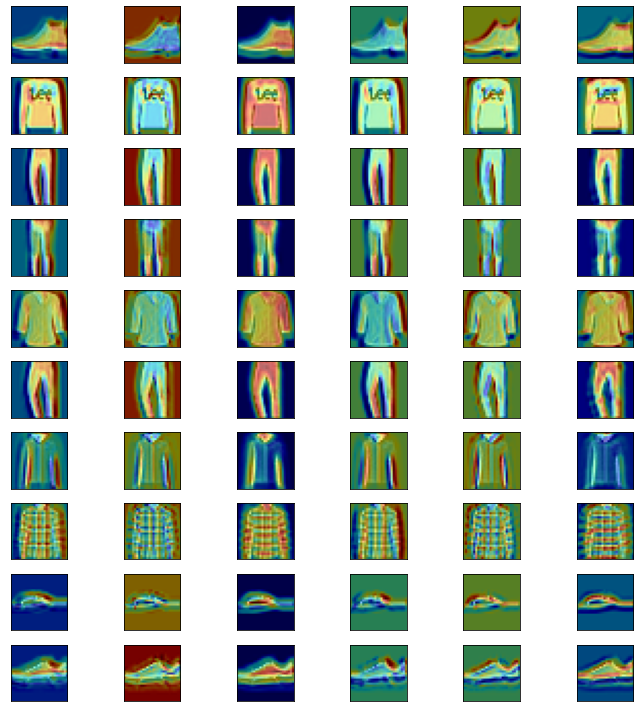

In [ ]:
show_conv_map(output_conv1[0].cpu(), data[:10].cpu(), (10,6)) #10 imágenes y 6 filtros

Vemos los 6 canales de la primera convolución de las 10 primeras imágenes del dataset. Podemos observar claros patrones en cada uno de los feature maps de cada prenda, ya que esta primera convolución se justifica con las figuras geométricas que crean las prendas.